# Importing Libraries

In [254]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#nltk
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

#sklearn
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import ConfusionMatrixDisplay

#sklearn models
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier, RandomForestClassifier

#train test split
from sklearn.model_selection import train_test_split

#re
import re

# Setting Variables

In [255]:
RANDOM_STATE = 1
np.random.seed(RANDOM_STATE)

# Loading Data

In [256]:
vc = pd.read_excel('Vintage Consumption.xlsx')

# Data Preparation

In [257]:
pd.set_option('display.max_columns', None)
vc.head()

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,RecipientFirstName,RecipientEmail,ExternalReference,LocationLatitude,LocationLongitude,DistributionChannel,UserLanguage,consent,ProlificID,scarcity_6,scarcity_9,scarcity_7,timing.IV_First Click,timing.IV_Last Click,timing.IV_Page Submit,timing.IV_Click Count,control_1,control_2,control_3,timing.IV.control_First Click,timing.IV.control_Last Click,timing.IV.control_Page Submit,timing.IV.control_Click Count,JacketM_1,JacketM_2,JacketM_3,ScooterM_1,ScooterM_2,ScooterM_3,WatchM_1,WatchM_2,WatchM_3,JacketV_1,JacketV_2,JacketV_3,ScooterV_1,ScooterV_2,ScooterV_3,WatchV_1,WatchV_2,WatchV_3,Nostalgia_1,Nostalgia_2,Intertemp.connection_1,Intertemp.connection_2,Intertemp.connection_3,Intertemp.connection_4,Intertemp.connection_5,Intertemp.connection_6,Intertemp.connection_7,Future Orientation_1,Future Orientation_2,Future Orientation_3,Future Orientation_4,manip_check_1,manip_check_2,manip_check_3,manip_check_4,meaning in life_1,meaning in life_2,meaning in life_3,meaning in life_4,meaning in life_5,meaning in life_6,meaning in life_7,meaning in life_8,meaning in life_9,meaning in life_10,meaning in life_11,need for uniqueness_1,need for uniqueness_2,need for uniqueness_3,need for uniqueness_4,need for uniqueness_5,need for uniqueness_6,need for uniqueness_7,need for uniqueness_8,need for uniqueness_9,need for uniqueness_10,need for uniqueness_11,need for uniqueness_12,Sustainability_1,Sustainability_2,Fresh Start Mindset_1,Fresh Start Mindset_2,Fresh Start Mindset_3,Fresh Start Mindset_4,Fresh Start Mindset_5,Fresh Start Mindset_6,Fresh Start Mindset_7,Fresh Start Mindset_8,Fresh Start Mindset_9,Fresh Start Mindset_10,Fresh Start Mindset_11,Fresh Start Mindset_12,Fresh Start Mindset_13,Fresh Start Mindset_14,BIS/BAS scale_1,BIS/BAS scale_2,BIS/BAS scale_3,BIS/BAS scale_4,BIS/BAS scale_5,BIS/BAS scale_6,BIS/BAS scale_7,BIS/BAS scale_8,BIS/BAS scale_9,BIS/BAS scale_10,BIS/BAS scale_11,BIS/BAS scale_12,BIS/BAS scale_13,BIS/BAS scale_14,BIS/BAS scale_15,BIS/BAS scale_16,BIS/BAS scale_17,BIS/BAS scale_18,BIS/BAS scale_19,BIS/BAS scale_20,BIS/BAS scale_21,BIS/BAS scale_22,BIS/BAS scale_23,BIS/BAS scale_24,gender,age,education,job,PROLIFIC_PID
0,Start Date,End Date,Response Type,IP Address,Progress,Duration (in seconds),Finished,Recorded Date,Response ID,Recipient Last Name,Recipient First Name,Recipient Email,External Data Reference,Location Latitude,Location Longitude,Distribution Channel,User Language,"Dear participant,\n\nThis is a study about con...",What is your Prolific ID? \nPlease note that t...,Adapted from Roux et al. (2015) - 1.,Adapted from Roux et al. (2015) - 2.,Adapted from Roux et al. (2015) - 3.,Timing - First Click,Timing - Last Click,Timing - Page Submit,Timing - Click Count,Roux et al. (2015) - 1.,Roux et al. (2015) - 2.,Roux et al. (2015) - 3.,Timing - First Click,Timing - Last Click,Timing - Page Submit,Timing - Click Count,Brand New Leather Jacket \n\n\n\nTan backgroun...,Brand New Leather Jacket \n\n\n\nTan backgroun...,Brand New Leather Jacket \n\n\n\nTan backgroun...,Brand New Model Scooter\n\n \n\nSPECIFICATIONS...,Brand New Model Scooter\n\n \n\nSPECIFICATIONS...,Brand New Model Scooter\n\n \n\nSPECIFICATIONS...,Imagine yourself wearing this $550 Modern watc...,Imagine yourself wearing this $550 Modern watc...,Imagine yourself wearing this $550 Modern watc...,Vintage Leather Jacket from 1970s\n\n\n\nTan b...,Vintage Leather Jacket from 1970s\n\n\n\nTan b...,Vintage Leather Jacket from 1970s\n\n\n\nTan b...,Vintage Scooter from 1975\n\n \n\nSPECIFICATIO...,Vintage Scooter from 1975\n\n \n\nSPECIFICATIO...,Vintage Scooter from 1975\n\n \n\nSPECIFICATIO...,Imagine yourself wearing this $550 Vintage wat...,Imagine yourself wearing this $550 Vintage wat...,Imagine yourself wearing this $550 Vintage wat...,Sarial-Abi et al. (2017) - I feel nostalgic at...,Sarial-Abi et al. (2017) - Right now I am havi...,S

In [258]:
#first column is a repetition of the title, we do not need it 
vc = vc.iloc[1: , :]

In [259]:
#columns needed for analysis
df1 = vc[['scarcity_6', 'scarcity_9', 'scarcity_7', 'control_1', 'control_2', 'control_3']].copy()

In [260]:
#combine all scarcity columns into one
df1['combined_scarcity'] = df1['scarcity_6']+' '+df1['scarcity_9']+' '+df1['scarcity_7']

#combine all control columns into one
df1['combined_control'] = df1['control_1']+' '+df1['control_2']+' '+df1['control_3']

In [261]:
#df_scarcity = df1[['combined_scarcity']]
#df_scarcity

In [262]:
#df_control = df1[['combined_control']]
#df_control

In [263]:
result = df1[['combined_scarcity', 'combined_control']]
result

,combined_scarcity,combined_control
1,NaN,shopping school party
2,NaN,study party rest
3,When I had to do work for school. When I had t...,NaN
4,NaN,went to school studied programmed
5,NaN,drink smoke had sex
...,...,...
217,NaN,NaN
218,NaN,NaN
219,NaN,NaN
220,NaN,walked to buy medicine and get pension for my ...


In [264]:
null_values = result[(result['combined_scarcity'].isnull()) & (result['combined_control'].isnull())]
null_values

,combined_scarcity,combined_control
208,NaN,NaN
209,NaN,NaN
210,NaN,NaN
211,NaN,NaN
212,NaN,NaN
213,NaN,NaN
214,NaN,NaN
215,NaN,NaN
216,NaN,NaN
217,NaN,NaN


In [265]:
#12 missing values -> fui confirmar ao excel e estes valores não existem
result.drop(result[(result['combined_scarcity'].isnull()) & (result['combined_control'].isnull())].index, inplace=True)
result

C:\Users\Joana Tavares\anaconda3\envs\bi\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,combined_scarcity,combined_control
1,NaN,shopping school party
2,NaN,study party rest
3,When I had to do work for school. When I had t...,NaN
4,NaN,went to school studied programmed
5,NaN,drink smoke had sex
...,...,...
205,NaN,Went to Convento de Cristo Dinned with some ni...
206,When I was at work When I tried to study When ...,NaN
207,When I had my last exams When I had a lot work...,NaN
220,NaN,walked to buy medicine and get pension for my ...


In [266]:
#fill NaN values with ''
result['combined_scarcity'] = result['combined_scarcity'].fillna('')
result['combined_control'] = result['combined_control'].fillna('')

C:\Users\JOANAT~1\AppData\Local\Temp/ipykernel_9052/1603878843.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['combined_scarcity'] = result['combined_scarcity'].fillna('')
C:\Users\JOANAT~1\AppData\Local\Temp/ipykernel_9052/1603878843.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['combined_control'] = result['combined_control'].fillna('')


In [267]:
#create our target column
result['target'] = 1*np.array(result['combined_scarcity']!="")

#create sentence column (join combined_scarcity and combined_control together)
result['sentence'] = result['combined_scarcity'] + result['combined_control']

C:\Users\JOANAT~1\AppData\Local\Temp/ipykernel_9052/2478008014.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['target'] = 1*np.array(result['combined_scarcity']!="")
C:\Users\JOANAT~1\AppData\Local\Temp/ipykernel_9052/2478008014.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['sentence'] = result['combined_scarcity'] + result['combined_control']


In [268]:
df = result.copy()

In [269]:
#we do not need combined_scarcity and combined_control, since we already joined both in sentence. we can drop those columns
df = df.drop(['combined_scarcity', 'combined_control'], axis=1)
df

,target,sentence
1,0,shopping school party
2,0,study party rest
3,1,When I had to do work for school. When I had t...
4,0,went to school studied programmed
5,0,drink smoke had sex
...,...,...
205,0,Went to Convento de Cristo Dinned with some ni...
206,1,When I was at work When I tried to study When ...
207,1,When I had my last exams When I had a lot work...
220,0,walked to buy medicine and get pension for my ...


In [270]:
#re arrange columns
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]
df

,sentence,target
1,shopping school party,0
2,study party rest,0
3,When I had to do work for school. When I had t...,1
4,went to school studied programmed,0
5,drink smoke had sex,0
...,...,...
205,Went to Convento de Cristo Dinned with some ni...,0
206,When I was at work When I tried to study When ...,1
207,When I had my last exams When I had a lot work...,1
220,walked to buy medicine and get pension for my ...,0


In [271]:
X = df.loc[:, ['sentence']]
y = df.loc[:, ['target']]

In [272]:
train, test = train_test_split(df, test_size=0.3)

# Baseline Preprocessing

In [273]:
stop = text.ENGLISH_STOP_WORDS
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [274]:
def stem_sentences(sentence):
    tokens = sentence.split()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

def lemmatize_sentences(sentence):
    tokens = sentence.split()
    lemmd_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmd_tokens)

def basic_preprocessing(df_, col, stop=[]):
    
    df = df_.copy()
    df['original'] = df[col]
    """
    Baseline preprocessing: 
        - lowercase
        - remove symbols (keep letters, ?, !)
        - remove stop words
        - use stemming
    """
    keep = ['?', '!']
    
    ## Lowercase
    df[col] = df[col].str.lower()
    
    ## Remove symbols
    df[col] = df[col].apply(lambda x: ''.join([re.sub(r'[\.;:,\"\'\/]','',x)]))
    
    ## Remove the extra space left before symbols
    ## e.g. "who are you ?" >> "who are you?"
    ## Not sure if this should be done, comment out if not
    ## df[col] = df[col].apply(lambda x: str.replace(x,' ?','?'))
    ## df[col] = df[col].apply(lambda x: str.replace(x,' !','!'))

    
    ## Remove stop words ?
    ## https://towardsdatascience.com/text-pre-processing-stop-words-removal-using-different-libraries-f20bac19929a
    if len(stop) > 0:
        df[col] = df[col].apply(lambda x: ' '.join([word for word in x.split(' ') if word not in (stop)]))
    
    ## Use Stemming
    df[col] = df[col].apply(lambda x: stem_sentences(x) )
    
    ## Remove excess space
    df[col] = df[col].str.strip()
    
    return df


def text_preprocessing(df_, col, stop=[]):
    
    df = df_.copy()
    df['original'] = df[col]
    """
    Baseline preprocessing: 
        - lowercase
        - remove symbols (keep letters, ?, !)
        - remove stop words in pipeline instead of in preprocessing
        - use lemmatizing instead 
    """
    keep = ['?', '!']
    
    ## Lowercase
    df[col] = df[col].str.lower()
    
    ## Remove symbols
    df[col] = df[col].apply(lambda x: ''.join([re.sub(r'[\.;:,\"\'\/]','',x)]))
        
    ## Use Lemmatizer
    df[col] = df[col].apply(lambda x: lemmatize_sentences(x) )
    
    ## Remove excess spaces
    df[col] = df[col].apply(lambda x: re.sub(' +', ' ', x))
    df[col] = df[col].str.strip()
    
    return df

In [275]:
train_set_prep_basic = basic_preprocessing(train, 'sentence', stop)
train_set_prep = text_preprocessing(train, 'sentence', stop)

In [276]:
dev_set_prep_basic = basic_preprocessing(test, 'sentence', stop)
dev_set_prep = text_preprocessing(test, 'sentence', stop)

# Data Understanding

In [277]:
labels = {
    0: 'control',
    1: 'scarcity'
}

In [278]:
X_train_basic = train_set_prep_basic['sentence']
Y_train_basic = train_set_prep_basic['target']

X_dev_basic = dev_set_prep_basic['sentence']
Y_dev_basic = dev_set_prep_basic['target']

In [279]:
X_train = train_set_prep['sentence']
Y_train = train_set_prep['target']

X_dev = dev_set_prep['sentence']
Y_dev = dev_set_prep['target']

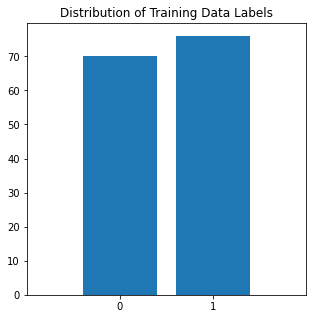

In [283]:
fig, ax = plt.subplots(figsize=(5,5))
y_counts = np.bincount(Y_train)
ax.bar(range(0,2), y_counts)
ax.set(xticks=range(0,2), xlim=[-1, 2])

plt.title("Distribution of Training Data Labels")
plt.show()

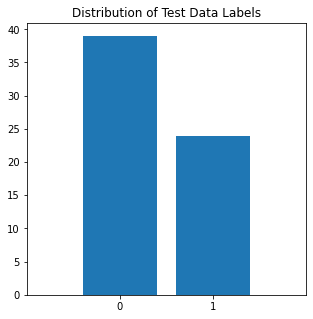

In [287]:
fig, ax = plt.subplots(figsize=(5,5))
y_counts = np.bincount(Y_dev)
ax.bar(range(0,2), y_counts)
ax.set(xticks=range(0,2), xlim=[-1, 2])

plt.title("Distribution of Test Data Labels")
plt.show()

# Model Selection

In [288]:
f1labels = ["F1 " + labels[i] for i in range(len(labels))]
rclabels = ["Recall " + labels[i] for i in range(len(labels))]
pclabels = ["Precision " + labels[i] for i in range(len(labels))]
numlabels = [i for i in range(len(labels))]

In [289]:
def get_scores(preds, label, cv_score, truth=Y_dev):
    return pd.DataFrame([[label,
               accuracy_score(truth, preds),
               recall_score(truth, preds, average='macro'),
               precision_score(truth, preds, average='macro'),
               f1_score(truth, preds, average='macro', ),
               cv_score,
               *(f1_score(truth, preds, average=None, labels=numlabels)),
               *(recall_score(truth, preds, average=None, labels=numlabels)),
               *(precision_score(truth, preds, average=None, labels=numlabels)),
            ]],
             columns=["Model", "Accuracy", "Recall", "Precision", "F1", "Train Accuracy", *f1labels, *rclabels, *pclabels ],
             index=[label]
        )
    
def print_scores(preds, gs_, Y=Y_dev):
    
    print("Best parameters: ")
    print(gs_.best_params_)
    print("------------------------")

    print("Accuracy:         ", round(accuracy_score(Y_dev, preds),4))
    print("Macro F1:         ", round(f1_score(Y_dev, preds, average='macro'),4))
    print("Macro Recall:     ", round(recall_score(Y_dev, preds, average='macro'),4))
    print("Macro Precision:  ", round(precision_score(Y_dev, preds, average='macro'),4))
    print("Best Train Score: ", round(gs_.best_score_,4))

    return

def plot_cm(preds, title, Y=Y_dev):
    cm_ = confusion_matrix(Y, preds)
    df_cm = pd.DataFrame(cm_, index=numlabels, columns=numlabels)
    
    fig, ax = plt.subplots(figsize=(7,5))
    
    ax = sns.heatmap(df_cm, annot=True,cmap="Blues", fmt="d")
    ax.set_ylabel("True Label")
    ax.set_xlabel("Predicted Label")
    
    plt.title("Confusion Matrix: "+title, fontsize=12)
    
    
    plt.show()
    #fn = './imgs03/ConfusionMatrix_' + title.replace(' ','-') + '.png'
    #fig.savefig(fn, bbox_inches='tight', transparent=True)
    
    return

In [290]:
score_func = 'accuracy'

# Baseline KNN

In [291]:
pipe_knn = Pipeline([
    ('count', CountVectorizer()),     # CountVectorizer 
    ('classifier', KNeighborsClassifier()),  # 
])

## Uses values of default params as grid search values
grid_knn = {
    "count__ngram_range": [(1,1)],
    "count__stop_words": [None],
}

gs_knn = GridSearchCV(pipe_knn, grid_knn, n_jobs=-1, cv=10, scoring=score_func)
gs_knn.fit(X_train_basic, Y_train_basic)
gs_knn_pred = gs_knn.predict(X_dev_basic)

Best parameters: 
{'count__ngram_range': (1, 1), 'count__stop_words': None}
------------------------
Accuracy:          0.7143
Macro F1:          0.65
Macro Recall:      0.649
Macro Precision:   0.7279
Best Train Score:  0.6443


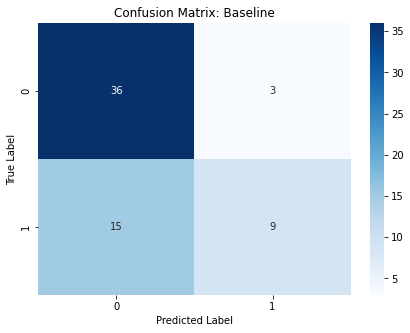

In [292]:
print_scores(gs_knn_pred, gs_knn)
scores = get_scores(gs_knn_pred, "KNN Baseline", gs_knn.best_score_)
plot_cm(gs_knn_pred, "Baseline")

## KNN Optimized

In [293]:
pipe_knno = Pipeline([
    ('count', CountVectorizer()),     # CountVectorizer 
    ('knn', KNeighborsClassifier()),  # 
])

## Uses values of default params as grid search values
grid_knno = {
    "count__ngram_range": [(1,1)],
    "count__stop_words": [None],
    "knn__n_neighbors": [20],
    "knn__metric": ['cosine'],
    
}

gs_knno = GridSearchCV(pipe_knno, grid_knno, n_jobs=-1, cv=10, scoring=score_func)
gs_knno.fit(X_train, Y_train)
gs_knno_pred = gs_knno.predict(X_dev)

Best parameters: 
{'count__ngram_range': (1, 1), 'count__stop_words': None, 'knn__metric': 'cosine', 'knn__n_neighbors': 20}
------------------------
Accuracy:          0.8254
Macro F1:          0.8209
Macro Recall:      0.8349
Macro Precision:   0.818
Best Train Score:  0.8895


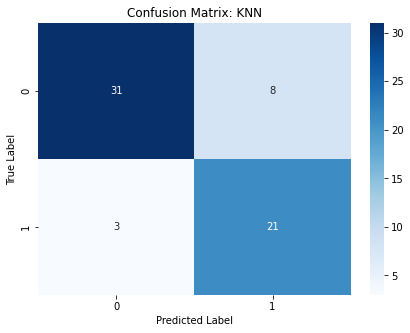

In [294]:
print_scores(gs_knno_pred, gs_knno)
scores = pd.concat([scores,get_scores(gs_knno_pred, "KNN", gs_knno.best_score_)])
plot_cm(gs_knno_pred, "KNN")

## MNB

In [295]:
pipe_mnb = Pipeline([
    ('count', CountVectorizer()),     # CountVectorizer 
    ('classifier', MultinomialNB()),  # 
])

## Uses values of default params as grid search values
grid_mnb = {
    "count__ngram_range": [(1,1)],
    "count__stop_words": [None],
    "classifier__alpha": [.5]
}

gs_mnb = GridSearchCV(pipe_mnb, grid_mnb, n_jobs=-1, cv=10, scoring=score_func)

gs_mnb.fit(X_train, Y_train)
gs_mnb_pred = gs_mnb.predict(X_dev)

Best parameters: 
{'classifier__alpha': 0.5, 'count__ngram_range': (1, 1), 'count__stop_words': None}
------------------------
Accuracy:          0.9048
Macro F1:          0.9005
Macro Recall:      0.9071
Macro Precision:   0.896
Best Train Score:  0.8967


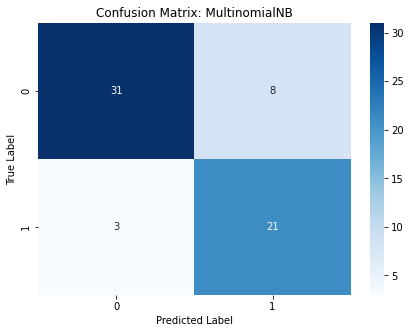

In [296]:
print_scores(gs_mnb_pred, gs_mnb)
scores = pd.concat([scores,get_scores(gs_mnb_pred, "MultinomialNB", gs_mnb.best_score_)])
plot_cm(gs_knno_pred, "MultinomialNB")

## SGD

In [297]:
pipe_sgd = Pipeline([
    ('count', CountVectorizer()),
    ('sgd', SGDClassifier(random_state=RANDOM_STATE, max_iter=3000)),
])

grid_sgd = {
    "count__ngram_range": [(1,1)],
    "count__stop_words": [None],
    "sgd__loss": ['log'],    
}

gs_sgd = GridSearchCV(pipe_sgd, grid_sgd, n_jobs=-1, cv=10, scoring=score_func)
gs_sgd.fit(X_train, Y_train)

gs_sgd_pred = gs_sgd.predict(X_dev)

In [298]:
print_scores(gs_sgd_pred, gs_sgd)
get_scores(gs_sgd_pred, "SGD", gs_sgd.best_score_)
scores = pd.concat([scores,get_scores(gs_sgd_pred, "SGDClassifier", gs_sgd.best_score_)])

Best parameters: 
{'count__ngram_range': (1, 1), 'count__stop_words': None, 'sgd__loss': 'log'}
------------------------
Accuracy:          0.9048
Macro F1:          0.899
Macro Recall:      0.899
Macro Precision:   0.899
Best Train Score:  0.8629


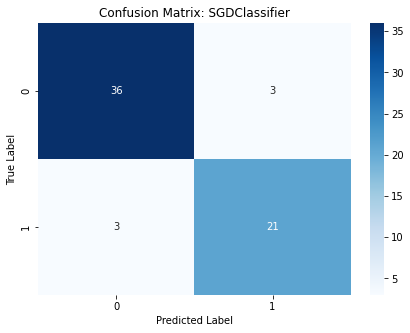

In [299]:
plot_cm(gs_sgd_pred, "SGDClassifier")

## LR

In [300]:
pipe_lr = Pipeline([
    ('count', CountVectorizer()),
    ('lr', LogisticRegression(random_state=RANDOM_STATE, max_iter=2000)),
])

grid_lr = {
    "count__ngram_range": [(1,1)],
    "count__stop_words": [None],
    "lr__solver": ['lbfgs'],
    "lr__multi_class": ['multinomial'],
    #"lr__": [],
}

gs_lr = GridSearchCV(pipe_lr, grid_lr, n_jobs=-1, cv=10, scoring=score_func)

gs_lr.fit(X_train, Y_train)
gs_lr_pred = gs_lr.predict(X_dev)

In [301]:
print_scores(gs_lr_pred, gs_lr)
get_scores(gs_lr_pred, "LogisticRegression", gs_lr.best_score_)

scores = pd.concat([scores,get_scores(gs_lr_pred, "LogisticRegression", gs_lr.best_score_)])

Best parameters: 
{'count__ngram_range': (1, 1), 'count__stop_words': None, 'lr__multi_class': 'multinomial', 'lr__solver': 'lbfgs'}
------------------------
Accuracy:          0.8889
Macro F1:          0.8764
Macro Recall:      0.8622
Macro Precision:   0.9055
Best Train Score:  0.9248


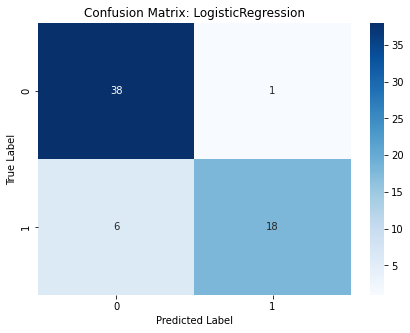

In [302]:
plot_cm(gs_lr_pred, "LogisticRegression")

## DT

In [303]:
pipe_dt = Pipeline([
    ('count', CountVectorizer()),
    ('dt', DecisionTreeClassifier(random_state=RANDOM_STATE)),
])

grid_dt = {
    "count__ngram_range": [(1,1), (2,4)],
    "count__stop_words": ["english", None],
    "dt__criterion": ['gini'],
    #"dt__": [],
    
}

gs_dt = GridSearchCV(pipe_dt, grid_dt, n_jobs=-1, cv=10, scoring=score_func)

gs_dt.fit(X_train, Y_train)
gs_dt_pred = gs_dt.predict(X_dev)

In [304]:
print_scores(gs_dt_pred, gs_dt)
get_scores(gs_dt_pred, "DecisionTreeClassifier", gs_dt.best_score_)

scores = pd.concat([scores,get_scores(gs_dt_pred, "DecisionTreeClassifier", gs_dt.best_score_)])

Best parameters: 
{'count__ngram_range': (1, 1), 'count__stop_words': None, 'dt__criterion': 'gini'}
------------------------
Accuracy:          0.8254
Macro F1:          0.8134
Macro Recall:      0.8109
Macro Precision:   0.8163
Best Train Score:  0.8371


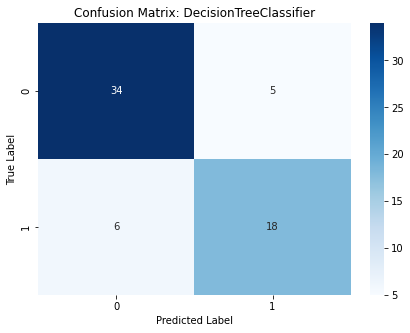

In [305]:
plot_cm(gs_dt_pred, "DecisionTreeClassifier")

## GB

In [306]:
pipe_gb = Pipeline([
    ('count', CountVectorizer()),
    ('gb', GradientBoostingClassifier(random_state=RANDOM_STATE)),
])

grid_gb = {
    "count__ngram_range": [(1,1)],
    "count__stop_words": [None],
    "gb__loss": ['deviance'],
    "gb__n_estimators": [200],
    "gb__learning_rate": [.25],    
}

gs_gb = GridSearchCV(pipe_gb, grid_gb, n_jobs=-1, cv=10, scoring=score_func)

gs_gb.fit(X_train, Y_train)
gs_gb_pred = gs_gb.predict(X_dev)


In [307]:
print_scores(gs_gb_pred, gs_gb)
get_scores(gs_gb_pred, "GradientBoostingClassifier", gs_gb.best_score_)

scores = pd.concat([scores,get_scores(gs_gb_pred, "GradientBoostingClassifier", gs_gb.best_score_)])

Best parameters: 
{'count__ngram_range': (1, 1), 'count__stop_words': None, 'gb__learning_rate': 0.25, 'gb__loss': 'deviance', 'gb__n_estimators': 200}
------------------------
Accuracy:          0.8413
Macro F1:          0.8254
Macro Recall:      0.8157
Macro Precision:   0.8436
Best Train Score:  0.8562


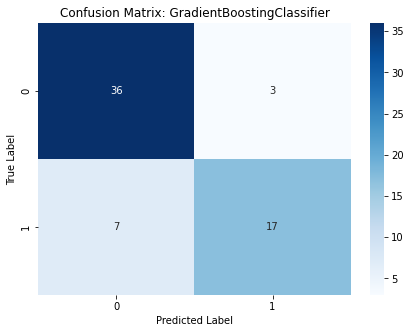

In [308]:
plot_cm(gs_gb_pred, "GradientBoostingClassifier")

## SVM

In [309]:
pipe_sv = Pipeline([
    ('count', CountVectorizer()),
    ('svc', SVC(random_state=RANDOM_STATE)),
])

grid_sv = {
    "count__ngram_range": [(1,1)],
    "count__stop_words": [None],
    "svc__kernel": ['linear'],
    "svc__decision_function_shape": ['ovo'],
}

gs_sv = GridSearchCV(pipe_sv, grid_sv, n_jobs=-1, cv=10, scoring=score_func)

gs_sv.fit(X_train, Y_train)
gs_sv_pred = gs_sv.predict(X_dev)

In [310]:
print_scores(gs_sv_pred, gs_sv)
get_scores(gs_sv_pred, "SVC", gs_sv.best_score_)

scores = pd.concat([scores,get_scores(gs_sv_pred, "SVC", gs_sv.best_score_)])

Best parameters: 
{'count__ngram_range': (1, 1), 'count__stop_words': None, 'svc__decision_function_shape': 'ovo', 'svc__kernel': 'linear'}
------------------------
Accuracy:          0.8889
Macro F1:          0.8764
Macro Recall:      0.8622
Macro Precision:   0.9055
Best Train Score:  0.9252


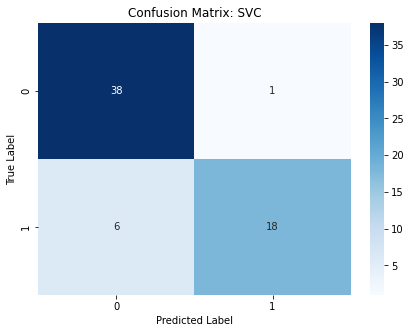

In [311]:
plot_cm(gs_sv_pred, "SVC")

## Voting Classifier

In [312]:
vc_ = VotingClassifier(
    estimators=[('lr', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)), 
                ('sg', SGDClassifier(random_state=RANDOM_STATE)), 
                ('nb', MultinomialNB()),
                ('gb', GradientBoostingClassifier(random_state=RANDOM_STATE)),
                ('sv', SVC(random_state=RANDOM_STATE))
               ],
    voting='hard'
)

vc_pipe_ = Pipeline([
        ('count', CountVectorizer()),    
        ('vc', vc_)
    ])


grid_vc_ = {
    "count__ngram_range": [(1,1)],
    "count__stop_words": [None]
}

gs_vc_ = GridSearchCV(vc_pipe_, grid_vc_, n_jobs=-1, cv=10, scoring=score_func)

gs_vc_.fit(X_train, Y_train)
gs_vc_pred_ = gs_vc_.predict(X_dev)

In [313]:
print_scores(gs_vc_pred_, gs_vc_)
get_scores(gs_vc_pred_, "VotingClassifier_NoTuning", gs_vc_.best_score_)

scores = pd.concat([scores,get_scores(gs_vc_pred_, "VotingClassifier_NoTuning", gs_vc_.best_score_)])

Best parameters: 
{'count__ngram_range': (1, 1), 'count__stop_words': None}
------------------------
Accuracy:          0.8889
Macro F1:          0.8764
Macro Recall:      0.8622
Macro Precision:   0.9055
Best Train Score:  0.9181


### Using optimized based estimators

In [314]:
vc = VotingClassifier(
    estimators=[('lr', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, solver='lbfgs', multi_class='multinomial')), 
                ('sg', SGDClassifier(random_state=RANDOM_STATE, loss='log')), 
                ('nb', MultinomialNB(alpha=.5)),
                ('gb', GradientBoostingClassifier(random_state=RANDOM_STATE, loss='deviance', n_estimators=200, learning_rate=.25)),
                ('sv', SVC(random_state=RANDOM_STATE, kernel='linear', decision_function_shape='ovo'))
               ],
    voting='hard'
)

vc_pipe = Pipeline([
        ('count', CountVectorizer()),    
        ('vc', vc)
    ])


grid_vc = {
    "count__ngram_range": [(1,1)],
    "count__stop_words": [None]
}

gs_vc = GridSearchCV(vc_pipe, grid_vc, n_jobs=-1, cv=10, scoring=score_func)

gs_vc.fit(X_train, Y_train)
gs_vc_pred = gs_vc.predict(X_dev)

In [315]:
print_scores(gs_vc_pred, gs_vc)
get_scores(gs_vc_pred, "VotingClassifier", gs_vc.best_score_)

scores = pd.concat([scores,get_scores(gs_vc_pred, "VotingClassifier", gs_vc.best_score_)])

Best parameters: 
{'count__ngram_range': (1, 1), 'count__stop_words': None}
------------------------
Accuracy:          0.8889
Macro F1:          0.8764
Macro Recall:      0.8622
Macro Precision:   0.9055
Best Train Score:  0.9248


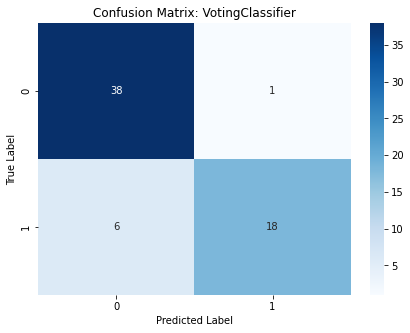

In [316]:
plot_cm(gs_vc_pred, "VotingClassifier")

## RF

In [317]:
pipe_rf = Pipeline([
    ('count', CountVectorizer()),
    ('rf', RandomForestClassifier(random_state=RANDOM_STATE)),
])

grid_rf = {
    "count__ngram_range": [(1,1)],
    "count__stop_words": [None],
    "rf__n_estimators": [200],
    "rf__criterion": ['gini'],

}

gs_rf = GridSearchCV(pipe_rf, grid_rf, n_jobs=-1, cv=10, scoring=score_func)

gs_rf.fit(X_train, Y_train)
gs_rf_pred = gs_rf.predict(X_dev)

In [318]:
print_scores(gs_rf_pred, gs_rf)
get_scores(gs_rf_pred, "RandomForestClassifier", gs_rf.best_score_)

scores = pd.concat([scores,get_scores(gs_rf_pred, "RandomForestClassifier", gs_rf.best_score_)])

Best parameters: 
{'count__ngram_range': (1, 1), 'count__stop_words': None, 'rf__criterion': 'gini', 'rf__n_estimators': 200}
------------------------
Accuracy:          0.873
Macro F1:          0.8603
Macro Recall:      0.8494
Macro Precision:   0.8802
Best Train Score:  0.8776


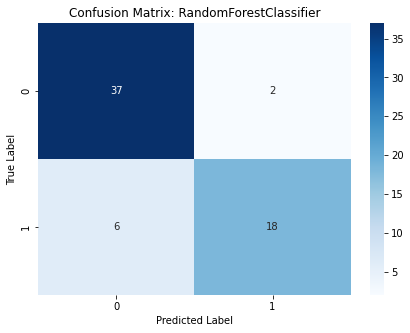

In [319]:
plot_cm(gs_rf_pred, "RandomForestClassifier")

In [320]:
scores.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

,Model,Accuracy,Recall,Precision,F1,Train Accuracy,F1 control,F1 scarcity,Recall control,Recall scarcity,Precision control,Precision scarcity
0,MultinomialNB,0.904762,0.907051,0.896050,0.900526,0.896667,0.921053,0.880000,0.897436,0.916667,0.945946,0.846154
1,SGDClassifier,0.904762,0.899038,0.899038,0.899038,0.862857,0.923077,0.875000,0.923077,0.875000,0.923077,0.875000
2,LogisticRegression,0.888889,0.862179,0.905502,0.876436,0.924762,0.915663,0.837209,0.974359,0.750000,0.863636,0.947368
3,SVC,0.888889,0.862179,0.905502,0.876436,0.925238,0.915663,0.837209,0.974359,0.750000,0.863636,0.947368
4,VotingClassifier_NoTuning,0.888889,0.862179,0.905502,0.876436,0.918095,0.915663,0.837209,0.974359,0.750000,0.863636,0.947368
5,VotingClassifier,0.888889,0.862179,0.905502,0.876436,0.924762,0.915663,0.837209,0.974359,0.750000,0.863636,0.947368
6,RandomForestClassifier,0.873016,0.849359,0.880233,0.860310,0.877619,0.902439,0.818182,0.948718,0.750000,0.860465,0.900000
7,GradientBoostingClassifier,0.841270,0.815705,0.843605,0.825388,0.856190,0.878049,0.772727,0.923077,0.708333,0.837209,0.850000
8,KNN,0.825397,0.834936,0.817951,0.820884,0.889524,0.849315,0.792453,0.794872,0.875000,0.911765,0.724138
9,DecisionTreeClassifier,0.825397,0.810897,0.816304,0.813358,0.837143,0.860759,0.765957,0.871795,0.750000,0.850000,0.782609


In [321]:
scores.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)\
        .to_csv('scores_countvectorizer.csv', index=False)